## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [3]:
!pip3 install cuda

  Could not find a version that satisfies the requirement cuda (from versions: )
No matching distribution found for cuda


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10631984882961153075
]


In [5]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [6]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [7]:
train, test = keras.datasets.cifar10.load_data()

In [8]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [9]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

# Hint 1 : 在 Dense 層中增加 Regularizers

In [10]:
from keras.regularizers import l1_l2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [12]:
results = {}
"""
Set your training loop
"""
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with L1 = 0.010000, L2 = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=============

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 145us/step - loss: 360.9924 - acc: 0.1747 - val_loss: 299.2470 - val_acc: 0.2474
Epoch 2/50
50000/50000 [==============================] - 6s 130us/step - loss: 237.5854 - acc: 0.2579 - val_loss: 177.6291 - val_acc: 0.2742
Epoch 3/50
50000/50000 [==============================] - 7s 131us/step - loss: 131.7777 - acc: 0.2737 - val_loss: 90.1635 - val_acc: 0.2730
Epoch 4/50
50000/50000 [==============================] - 6s 129us/step - loss: 62.9524 - acc: 0.2605 - val_loss: 41.0310 - val_acc: 0.2601
Epoch 5/50
50000/50000 [==============================] - 7s 132us/step - loss: 31.7829 - acc: 0.1748 - val_loss: 25.1192 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 6s 129us/step - loss: 20.9604 - acc: 0.1000 - val_loss: 17.1492 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 6s 130us/step - loss: 14.1901 - acc: 0.1000 - v

50000/50000 [==============================] - 7s 145us/step - loss: 361.1639 - acc: 0.1785 - val_loss: 299.4805 - val_acc: 0.2456
Epoch 2/50
50000/50000 [==============================] - 6s 129us/step - loss: 237.8658 - acc: 0.2556 - val_loss: 177.9345 - val_acc: 0.2567
Epoch 3/50
50000/50000 [==============================] - 6s 129us/step - loss: 132.1011 - acc: 0.2600 - val_loss: 90.4785 - val_acc: 0.2567
Epoch 4/50
50000/50000 [==============================] - 6s 129us/step - loss: 63.2348 - acc: 0.2590 - val_loss: 41.2805 - val_acc: 0.2632
Epoch 5/50
50000/50000 [==============================] - 6s 129us/step - loss: 31.9728 - acc: 0.1737 - val_loss: 25.2863 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 7s 130us/step - loss: 21.1125 - acc: 0.1000 - val_loss: 17.2840 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 6s 130us/step - loss: 14.3077 - acc: 0.1000 - val_loss: 11.4735 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==

50000/50000 [==============================] - 6s 130us/step - loss: 237.7180 - acc: 0.2609 - val_loss: 177.7740 - val_acc: 0.2595
Epoch 3/50
50000/50000 [==============================] - 6s 128us/step - loss: 131.9356 - acc: 0.2666 - val_loss: 90.3224 - val_acc: 0.2705
Epoch 4/50
50000/50000 [==============================] - 6s 128us/step - loss: 63.0981 - acc: 0.2709 - val_loss: 41.1384 - val_acc: 0.2568
Epoch 5/50
50000/50000 [==============================] - 6s 128us/step - loss: 31.8452 - acc: 0.1720 - val_loss: 25.1639 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 6s 128us/step - loss: 20.9980 - acc: 0.1000 - val_loss: 17.1821 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 6s 128us/step - loss: 14.2197 - acc: 0.1000 - val_loss: 11.4006 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 6s 129us/step - loss: 9.2566 - acc: 0.1000 - val_loss: 7.2949 - val_acc: 0.1000
Epoch 9/50
50000/50000 [======

50000/50000 [==============================] - 7s 131us/step - loss: 131.4685 - acc: 0.2724 - val_loss: 89.9446 - val_acc: 0.2698
Epoch 4/50
50000/50000 [==============================] - 7s 143us/step - loss: 62.8100 - acc: 0.2717 - val_loss: 40.9496 - val_acc: 0.2599
Epoch 5/50
50000/50000 [==============================] - 7s 133us/step - loss: 31.6972 - acc: 0.1800 - val_loss: 25.0489 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 6s 128us/step - loss: 20.9051 - acc: 0.1000 - val_loss: 17.1117 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 6s 128us/step - loss: 14.1623 - acc: 0.1000 - val_loss: 11.3553 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 7s 140us/step - loss: 9.2180 - acc: 0.1000 - val_loss: 7.2622 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 7s 139us/step - loss: 5.9362 - acc: 0.1000 - val_loss: 4.8273 - val_acc: 0.1000
Epoch 10/50
50000/50000 [=========

50000/50000 [==============================] - 7s 147us/step - loss: 17.6627 - acc: 0.3420 - val_loss: 17.3211 - val_acc: 0.3491
Epoch 5/50
50000/50000 [==============================] - 7s 146us/step - loss: 17.0113 - acc: 0.3535 - val_loss: 16.6877 - val_acc: 0.3576
Epoch 6/50
50000/50000 [==============================] - 7s 140us/step - loss: 16.3917 - acc: 0.3639 - val_loss: 16.0815 - val_acc: 0.3693
Epoch 7/50
50000/50000 [==============================] - 7s 143us/step - loss: 15.7996 - acc: 0.3719 - val_loss: 15.5041 - val_acc: 0.3760
Epoch 8/50
50000/50000 [==============================] - 7s 141us/step - loss: 15.2321 - acc: 0.3778 - val_loss: 14.9482 - val_acc: 0.3798
Epoch 9/50
50000/50000 [==============================] - 7s 138us/step - loss: 14.6884 - acc: 0.3837 - val_loss: 14.4158 - val_acc: 0.3908
Epoch 10/50
50000/50000 [==============================] - 7s 140us/step - loss: 14.1671 - acc: 0.3885 - val_loss: 13.9067 - val_acc: 0.3920
Epoch 11/50
50000/50000 [=====

Epoch 5/50
50000/50000 [==============================] - 7s 136us/step - loss: 5.9012 - acc: 0.3580 - val_loss: 5.8769 - val_acc: 0.3600
Epoch 6/50
50000/50000 [==============================] - 7s 144us/step - loss: 5.8506 - acc: 0.3708 - val_loss: 5.8288 - val_acc: 0.3758
Epoch 7/50
50000/50000 [==============================] - 8s 157us/step - loss: 5.8052 - acc: 0.3796 - val_loss: 5.7858 - val_acc: 0.3883
Epoch 8/50
50000/50000 [==============================] - 8s 157us/step - loss: 5.7639 - acc: 0.3893 - val_loss: 5.7480 - val_acc: 0.3851
Epoch 9/50
50000/50000 [==============================] - 8s 158us/step - loss: 5.7256 - acc: 0.3950 - val_loss: 5.7095 - val_acc: 0.3954
Epoch 10/50
50000/50000 [==============================] - 7s 149us/step - loss: 5.6895 - acc: 0.4033 - val_loss: 5.6759 - val_acc: 0.4040
Epoch 11/50
50000/50000 [==============================] - 7s 144us/step - loss: 5.6556 - acc: 0.4099 - val_loss: 5.6429 - val_acc: 0.4089
Epoch 12/50
50000/50000 [=======

50000/50000 [==============================] - 7s 148us/step - loss: 5.7296 - acc: 0.3686 - val_loss: 5.7103 - val_acc: 0.3721
Epoch 7/50
50000/50000 [==============================] - 7s 150us/step - loss: 5.6874 - acc: 0.3766 - val_loss: 5.6711 - val_acc: 0.3813
Epoch 8/50
50000/50000 [==============================] - 8s 154us/step - loss: 5.6489 - acc: 0.3842 - val_loss: 5.6330 - val_acc: 0.3876
Epoch 9/50
50000/50000 [==============================] - 8s 160us/step - loss: 5.6123 - acc: 0.3914 - val_loss: 5.6001 - val_acc: 0.3916
Epoch 10/50
50000/50000 [==============================] - 7s 148us/step - loss: 5.5782 - acc: 0.3972 - val_loss: 5.5651 - val_acc: 0.3971
Epoch 11/50
50000/50000 [==============================] - 7s 144us/step - loss: 5.5451 - acc: 0.4024 - val_loss: 5.5344 - val_acc: 0.4027
Epoch 12/50
50000/50000 [==============================] - 7s 142us/step - loss: 5.5137 - acc: 0.4083 - val_loss: 5.5071 - val_acc: 0.4014
Epoch 13/50
50000/50000 [=================

50000/50000 [==============================] - 7s 142us/step - loss: 5.6676 - acc: 0.3810 - val_loss: 5.6476 - val_acc: 0.3824
Epoch 8/50
50000/50000 [==============================] - 7s 147us/step - loss: 5.6284 - acc: 0.3878 - val_loss: 5.6073 - val_acc: 0.3944
Epoch 9/50
50000/50000 [==============================] - 7s 146us/step - loss: 5.5902 - acc: 0.3959 - val_loss: 5.5720 - val_acc: 0.3974
Epoch 10/50
50000/50000 [==============================] - 7s 142us/step - loss: 5.5555 - acc: 0.4015 - val_loss: 5.5382 - val_acc: 0.4062
Epoch 11/50
50000/50000 [==============================] - 7s 144us/step - loss: 5.5225 - acc: 0.4088 - val_loss: 5.5075 - val_acc: 0.4131
Epoch 12/50
50000/50000 [==============================] - 8s 151us/step - loss: 5.4909 - acc: 0.4143 - val_loss: 5.4779 - val_acc: 0.4164
Epoch 13/50
50000/50000 [==============================] - 8s 152us/step - loss: 5.4607 - acc: 0.4197 - val_loss: 5.4489 - val_acc: 0.4192
Epoch 14/50
50000/50000 [================

50000/50000 [==============================] - 7s 142us/step - loss: 5.6419 - acc: 0.3886 - val_loss: 5.6252 - val_acc: 0.3903
Epoch 9/50
50000/50000 [==============================] - 7s 145us/step - loss: 5.6056 - acc: 0.3952 - val_loss: 5.5908 - val_acc: 0.3989
Epoch 10/50
50000/50000 [==============================] - 7s 141us/step - loss: 5.5708 - acc: 0.4036 - val_loss: 5.5564 - val_acc: 0.4012
Epoch 11/50
50000/50000 [==============================] - 7s 137us/step - loss: 5.5375 - acc: 0.4089 - val_loss: 5.5258 - val_acc: 0.4047
Epoch 12/50
50000/50000 [==============================] - 7s 146us/step - loss: 5.5053 - acc: 0.4146 - val_loss: 5.4933 - val_acc: 0.4126
Epoch 13/50
50000/50000 [==============================] - 8s 163us/step - loss: 5.4750 - acc: 0.4199 - val_loss: 5.4643 - val_acc: 0.4163
Epoch 14/50
50000/50000 [==============================] - 8s 151us/step - loss: 5.4450 - acc: 0.4248 - val_loss: 5.4370 - val_acc: 0.4172
Epoch 15/50
50000/50000 [===============

50000/50000 [==============================] - 6s 128us/step - loss: 11.9256 - acc: 0.3824 - val_loss: 11.7174 - val_acc: 0.3878
Epoch 10/50
50000/50000 [==============================] - 6s 129us/step - loss: 11.5261 - acc: 0.3882 - val_loss: 11.3279 - val_acc: 0.3875
Epoch 11/50
50000/50000 [==============================] - 6s 130us/step - loss: 11.1437 - acc: 0.3923 - val_loss: 10.9525 - val_acc: 0.3979
Epoch 12/50
50000/50000 [==============================] - 6s 128us/step - loss: 10.7761 - acc: 0.3960 - val_loss: 10.5937 - val_acc: 0.3965
Epoch 13/50
50000/50000 [==============================] - 6s 129us/step - loss: 10.4240 - acc: 0.3988 - val_loss: 10.2490 - val_acc: 0.4001
Epoch 14/50
50000/50000 [==============================] - 6s 128us/step - loss: 10.0853 - acc: 0.4039 - val_loss: 9.9175 - val_acc: 0.4057
Epoch 15/50
50000/50000 [==============================] - 6s 129us/step - loss: 9.7606 - acc: 0.4048 - val_loss: 9.6001 - val_acc: 0.4060
Epoch 16/50
50000/50000 [===

50000/50000 [==============================] - 6s 130us/step - loss: 1.8572 - acc: 0.4024 - val_loss: 1.8524 - val_acc: 0.4023
Epoch 11/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.8388 - acc: 0.4093 - val_loss: 1.8365 - val_acc: 0.4067
Epoch 12/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.8222 - acc: 0.4147 - val_loss: 1.8195 - val_acc: 0.4127
Epoch 13/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.8074 - acc: 0.4194 - val_loss: 1.8051 - val_acc: 0.4186
Epoch 14/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.7922 - acc: 0.4249 - val_loss: 1.7946 - val_acc: 0.4215
Epoch 15/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.7783 - acc: 0.4317 - val_loss: 1.7808 - val_acc: 0.4217
Epoch 16/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.7650 - acc: 0.4350 - val_loss: 1.7686 - val_acc: 0.4281
Epoch 17/50
50000/50000 [==============

50000/50000 [==============================] - 6s 128us/step - loss: 1.7115 - acc: 0.4030 - val_loss: 1.7066 - val_acc: 0.4077
Epoch 12/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.6962 - acc: 0.4075 - val_loss: 1.6918 - val_acc: 0.4094
Epoch 13/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.6817 - acc: 0.4135 - val_loss: 1.6780 - val_acc: 0.4169
Epoch 14/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.6670 - acc: 0.4179 - val_loss: 1.6655 - val_acc: 0.4189
Epoch 15/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.6535 - acc: 0.4237 - val_loss: 1.6508 - val_acc: 0.4211
Epoch 16/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.6403 - acc: 0.4284 - val_loss: 1.6396 - val_acc: 0.4264
Epoch 17/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.6274 - acc: 0.4324 - val_loss: 1.6274 - val_acc: 0.4311
Epoch 18/50
50000/50000 [==============

50000/50000 [==============================] - 6s 128us/step - loss: 1.6795 - acc: 0.4154 - val_loss: 1.6792 - val_acc: 0.4192
Epoch 13/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.6640 - acc: 0.4207 - val_loss: 1.6695 - val_acc: 0.4183
Epoch 14/50
50000/50000 [==============================] - 6s 130us/step - loss: 1.6495 - acc: 0.4257 - val_loss: 1.6520 - val_acc: 0.4239
Epoch 15/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.6357 - acc: 0.4310 - val_loss: 1.6408 - val_acc: 0.4313
Epoch 16/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.6228 - acc: 0.4367 - val_loss: 1.6283 - val_acc: 0.4339
Epoch 17/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.6099 - acc: 0.4419 - val_loss: 1.6178 - val_acc: 0.4333
Epoch 18/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.5980 - acc: 0.4453 - val_loss: 1.6062 - val_acc: 0.4406
Epoch 19/50
50000/50000 [==============

50000/50000 [==============================] - 6s 122us/step - loss: 1.6623 - acc: 0.4200 - val_loss: 1.6603 - val_acc: 0.4188
Epoch 14/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.6469 - acc: 0.4263 - val_loss: 1.6470 - val_acc: 0.4293
Epoch 15/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.6332 - acc: 0.4317 - val_loss: 1.6333 - val_acc: 0.4328
Epoch 16/50
50000/50000 [==============================] - 6s 126us/step - loss: 1.6189 - acc: 0.4362 - val_loss: 1.6257 - val_acc: 0.4335
Epoch 17/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.6068 - acc: 0.4409 - val_loss: 1.6105 - val_acc: 0.4403
Epoch 18/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.5939 - acc: 0.4446 - val_loss: 1.6016 - val_acc: 0.4446
Epoch 19/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.5824 - acc: 0.4490 - val_loss: 1.5914 - val_acc: 0.4472
Epoch 20/50
50000/50000 [==============

50000/50000 [==============================] - 6s 130us/step - loss: 10.0523 - acc: 0.3995 - val_loss: 9.8849 - val_acc: 0.3966
Epoch 15/50
50000/50000 [==============================] - 6s 129us/step - loss: 9.7280 - acc: 0.4034 - val_loss: 9.5679 - val_acc: 0.4002
Epoch 16/50
50000/50000 [==============================] - 6s 130us/step - loss: 9.4169 - acc: 0.4056 - val_loss: 9.2644 - val_acc: 0.4018
Epoch 17/50
50000/50000 [==============================] - 6s 130us/step - loss: 9.1181 - acc: 0.4086 - val_loss: 8.9720 - val_acc: 0.4039
Epoch 18/50
50000/50000 [==============================] - 6s 128us/step - loss: 8.8316 - acc: 0.4108 - val_loss: 8.6901 - val_acc: 0.4063
Epoch 19/50
50000/50000 [==============================] - 6s 128us/step - loss: 8.5563 - acc: 0.4144 - val_loss: 8.4191 - val_acc: 0.4110
Epoch 20/50
50000/50000 [==============================] - 6s 127us/step - loss: 8.2909 - acc: 0.4152 - val_loss: 8.1604 - val_acc: 0.4161
Epoch 21/50
50000/50000 [=============

50000/50000 [==============================] - 6s 127us/step - loss: 1.7769 - acc: 0.4296 - val_loss: 1.7761 - val_acc: 0.4294
Epoch 16/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.7632 - acc: 0.4347 - val_loss: 1.7657 - val_acc: 0.4311
Epoch 17/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.7508 - acc: 0.4404 - val_loss: 1.7562 - val_acc: 0.4321
Epoch 18/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.7391 - acc: 0.4438 - val_loss: 1.7439 - val_acc: 0.4402
Epoch 19/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.7271 - acc: 0.4471 - val_loss: 1.7342 - val_acc: 0.4398
Epoch 20/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.7163 - acc: 0.4516 - val_loss: 1.7240 - val_acc: 0.4484
Epoch 21/50
50000/50000 [==============================] - 7s 134us/step - loss: 1.7049 - acc: 0.4548 - val_loss: 1.7129 - val_acc: 0.4518
Epoch 22/50
50000/50000 [==============

50000/50000 [==============================] - 6s 128us/step - loss: 1.6313 - acc: 0.4308 - val_loss: 1.6321 - val_acc: 0.4307
Epoch 17/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.6195 - acc: 0.4338 - val_loss: 1.6198 - val_acc: 0.4371
Epoch 18/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.6082 - acc: 0.4384 - val_loss: 1.6107 - val_acc: 0.4392
Epoch 19/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.5968 - acc: 0.4429 - val_loss: 1.6000 - val_acc: 0.4432
Epoch 20/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.5861 - acc: 0.4467 - val_loss: 1.5910 - val_acc: 0.4469
Epoch 21/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.5765 - acc: 0.4508 - val_loss: 1.5838 - val_acc: 0.4498
Epoch 22/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.5656 - acc: 0.4532 - val_loss: 1.5759 - val_acc: 0.4496
Epoch 23/50
50000/50000 [==============

50000/50000 [==============================] - 6s 128us/step - loss: 1.6089 - acc: 0.4358 - val_loss: 1.6157 - val_acc: 0.4350
Epoch 18/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.5970 - acc: 0.4402 - val_loss: 1.6028 - val_acc: 0.4434
Epoch 19/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.5860 - acc: 0.4443 - val_loss: 1.5933 - val_acc: 0.4448
Epoch 20/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.5752 - acc: 0.4494 - val_loss: 1.5844 - val_acc: 0.4458
Epoch 21/50
50000/50000 [==============================] - 6s 128us/step - loss: 1.5648 - acc: 0.4535 - val_loss: 1.5759 - val_acc: 0.4509
Epoch 22/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.5546 - acc: 0.4566 - val_loss: 1.5686 - val_acc: 0.4521
Epoch 23/50
50000/50000 [==============================] - 6s 129us/step - loss: 1.5458 - acc: 0.4599 - val_loss: 1.5604 - val_acc: 0.4537
Epoch 24/50
50000/50000 [==============

50000/50000 [==============================] - 6s 124us/step - loss: 1.6139 - acc: 0.4370 - val_loss: 1.6205 - val_acc: 0.4314
Epoch 19/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.6025 - acc: 0.4392 - val_loss: 1.6056 - val_acc: 0.4387
Epoch 20/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.5911 - acc: 0.4449 - val_loss: 1.5971 - val_acc: 0.4425
Epoch 21/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.5804 - acc: 0.4484 - val_loss: 1.5918 - val_acc: 0.4439
Epoch 22/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.5699 - acc: 0.4516 - val_loss: 1.5783 - val_acc: 0.4508
Epoch 23/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.5605 - acc: 0.4552 - val_loss: 1.5718 - val_acc: 0.4502
Epoch 24/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.5504 - acc: 0.4589 - val_loss: 1.5628 - val_acc: 0.4539
Epoch 25/50
50000/50000 [==============

50000/50000 [==============================] - 6s 122us/step - loss: 8.5745 - acc: 0.4114 - val_loss: 8.4376 - val_acc: 0.4161
Epoch 20/50
50000/50000 [==============================] - 6s 123us/step - loss: 8.3085 - acc: 0.4140 - val_loss: 8.1786 - val_acc: 0.4166
Epoch 21/50
50000/50000 [==============================] - 6s 129us/step - loss: 8.0539 - acc: 0.4150 - val_loss: 7.9295 - val_acc: 0.4143
Epoch 22/50
50000/50000 [==============================] - 6s 123us/step - loss: 7.8082 - acc: 0.4169 - val_loss: 7.6884 - val_acc: 0.4185
Epoch 23/50
50000/50000 [==============================] - 6s 124us/step - loss: 7.5725 - acc: 0.4205 - val_loss: 7.4572 - val_acc: 0.4192
Epoch 24/50
50000/50000 [==============================] - 6s 123us/step - loss: 7.3459 - acc: 0.4208 - val_loss: 7.2353 - val_acc: 0.4231
Epoch 25/50
50000/50000 [==============================] - 6s 122us/step - loss: 7.1277 - acc: 0.4234 - val_loss: 7.0237 - val_acc: 0.4250
Epoch 26/50
50000/50000 [==============

50000/50000 [==============================] - 6s 123us/step - loss: 1.7077 - acc: 0.4536 - val_loss: 1.7172 - val_acc: 0.4490
Epoch 21/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.6965 - acc: 0.4590 - val_loss: 1.7080 - val_acc: 0.4492
Epoch 22/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.6869 - acc: 0.4618 - val_loss: 1.7041 - val_acc: 0.4483
Epoch 23/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.6771 - acc: 0.4654 - val_loss: 1.6928 - val_acc: 0.4561
Epoch 24/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.6684 - acc: 0.4672 - val_loss: 1.6858 - val_acc: 0.4541
Epoch 25/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.6600 - acc: 0.4709 - val_loss: 1.6789 - val_acc: 0.4569
Epoch 26/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.6509 - acc: 0.4743 - val_loss: 1.6714 - val_acc: 0.4606
Epoch 27/50
50000/50000 [==============

50000/50000 [==============================] - 6s 124us/step - loss: 1.5676 - acc: 0.4518 - val_loss: 1.5751 - val_acc: 0.4476
Epoch 22/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.5569 - acc: 0.4567 - val_loss: 1.5704 - val_acc: 0.4500
Epoch 23/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.5479 - acc: 0.4576 - val_loss: 1.5575 - val_acc: 0.4547
Epoch 24/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.5378 - acc: 0.4622 - val_loss: 1.5512 - val_acc: 0.4576
Epoch 25/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.5284 - acc: 0.4651 - val_loss: 1.5458 - val_acc: 0.4579
Epoch 26/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.5198 - acc: 0.4691 - val_loss: 1.5386 - val_acc: 0.4571
Epoch 27/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.5116 - acc: 0.4718 - val_loss: 1.5324 - val_acc: 0.4609
Epoch 28/50
50000/50000 [==============

50000/50000 [==============================] - 6s 123us/step - loss: 1.5382 - acc: 0.4633 - val_loss: 1.5581 - val_acc: 0.4490
Epoch 23/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.5283 - acc: 0.4673 - val_loss: 1.5489 - val_acc: 0.4509
Epoch 24/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.5200 - acc: 0.4691 - val_loss: 1.5431 - val_acc: 0.4555
Epoch 25/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.5100 - acc: 0.4731 - val_loss: 1.5334 - val_acc: 0.4566
Epoch 26/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.5013 - acc: 0.4763 - val_loss: 1.5296 - val_acc: 0.4557
Epoch 27/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.4932 - acc: 0.4801 - val_loss: 1.5192 - val_acc: 0.4615
Epoch 28/50
50000/50000 [==============================] - 6s 123us/step - loss: 1.4836 - acc: 0.4828 - val_loss: 1.5155 - val_acc: 0.4635
Epoch 29/50
50000/50000 [==============

50000/50000 [==============================] - 6s 118us/step - loss: 1.5371 - acc: 0.4629 - val_loss: 1.5511 - val_acc: 0.4538
Epoch 24/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.5277 - acc: 0.4679 - val_loss: 1.5440 - val_acc: 0.4566
Epoch 25/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.5185 - acc: 0.4711 - val_loss: 1.5411 - val_acc: 0.4605
Epoch 26/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.5108 - acc: 0.4729 - val_loss: 1.5282 - val_acc: 0.4595
Epoch 27/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.5013 - acc: 0.4764 - val_loss: 1.5214 - val_acc: 0.4654
Epoch 28/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.4930 - acc: 0.4790 - val_loss: 1.5221 - val_acc: 0.4649
Epoch 29/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.4859 - acc: 0.4813 - val_loss: 1.5122 - val_acc: 0.4668
Epoch 30/50
50000/50000 [==============

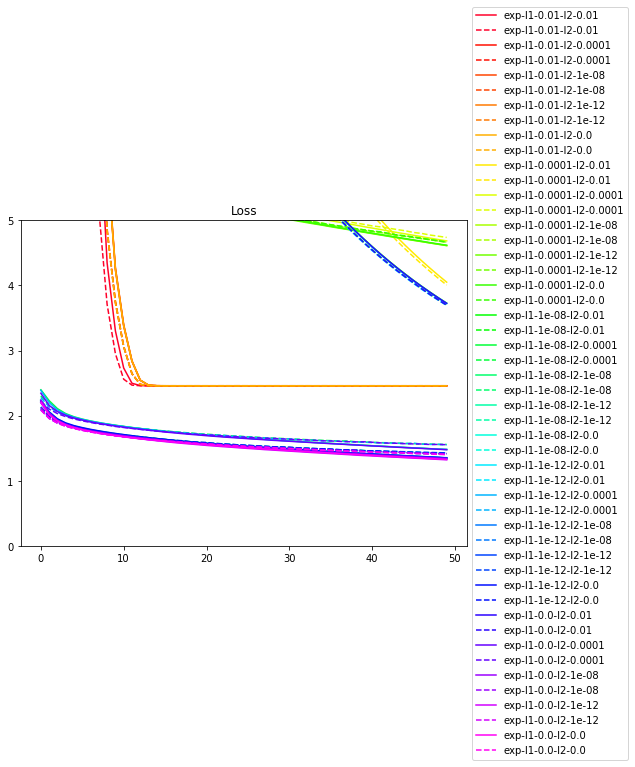

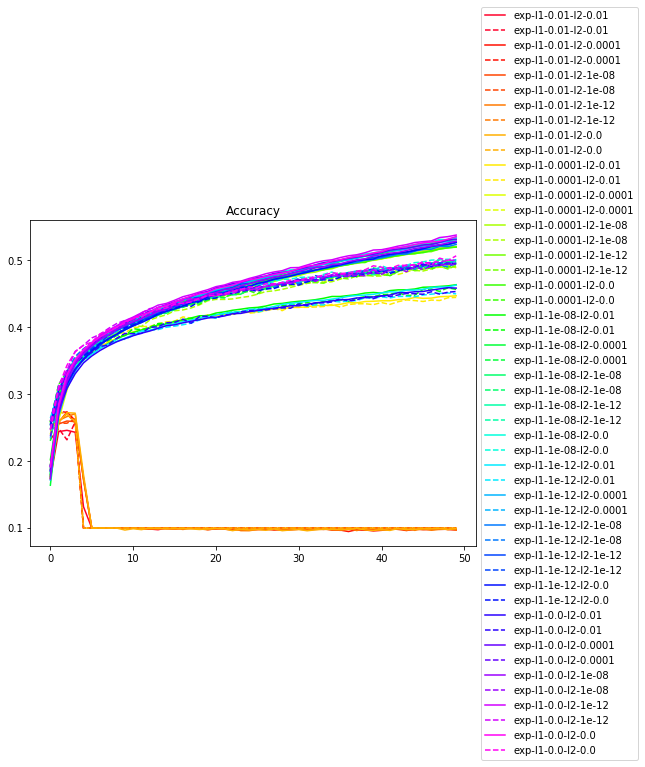

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
plot the results
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# Hint 2 : 增加 Dropout 層並設定 dropout ratio 

In [16]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [17]:
## 超參數設定
"""
Set Hyper-parameters here
"""
LEARNING_RATE = 1e-4
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = 0.2

In [18]:
from keras.layers import Dropout
model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=Dropout_EXP)
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

50000/50000 [==============================] - 9s 176us/step - loss: 1.7189 - acc: 0.3891 - val_loss: 1.6410 - val_acc: 0.4197
Epoch 50/50
50000/50000 [==============================] - 11s 211us/step - loss: 1.7124 - acc: 0.3906 - val_loss: 1.6355 - val_acc: 0.4246


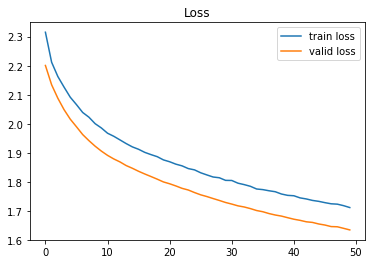

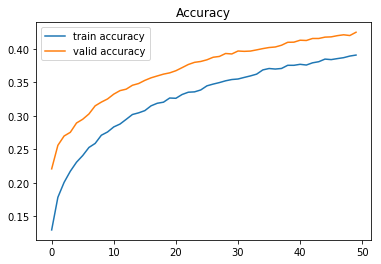

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

# Hint 3 : 增加 Batch-normalization 層

In [20]:
from keras.layers import BatchNormalization, Activation
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre_activate=False):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            if pre_activate:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
            else:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [21]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [128, 256, 512, 1024]
MOMENTUM = 0.95

In [25]:
results = {}
"""
Write your training loop and record results
"""
for batch_size in BATCH_SIZE:
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test),
              shuffle=True)
    
    # Collect results
    exp_name_tag = ("exp-%s" % (batch_size))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_16 (Activation)   (None, 512)               0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
activation_17 (Activation)   (None, 256)               0         
__________

50000/50000 [==============================] - 13s 257us/step - loss: 0.2881 - acc: 0.9061 - val_loss: 2.2522 - val_acc: 0.4761
Epoch 47/50
50000/50000 [==============================] - 13s 261us/step - loss: 0.2858 - acc: 0.9068 - val_loss: 2.3618 - val_acc: 0.4600
Epoch 48/50
50000/50000 [==============================] - 13s 267us/step - loss: 0.2719 - acc: 0.9110 - val_loss: 2.3610 - val_acc: 0.4538
Epoch 49/50
50000/50000 [==============================] - 13s 251us/step - loss: 0.2563 - acc: 0.9179 - val_loss: 2.2534 - val_acc: 0.4831
Epoch 50/50
50000/50000 [==============================] - 12s 244us/step - loss: 0.2346 - acc: 0.9270 - val_loss: 2.2590 - val_acc: 0.4866
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)        

Epoch 42/50
50000/50000 [==============================] - 9s 183us/step - loss: 0.3303 - acc: 0.9032 - val_loss: 1.9048 - val_acc: 0.4923
Epoch 43/50
50000/50000 [==============================] - 9s 184us/step - loss: 0.3107 - acc: 0.9102 - val_loss: 2.0488 - val_acc: 0.4767
Epoch 44/50
50000/50000 [==============================] - 9s 185us/step - loss: 0.3034 - acc: 0.9124 - val_loss: 2.0869 - val_acc: 0.4730
Epoch 45/50
50000/50000 [==============================] - 9s 184us/step - loss: 0.2904 - acc: 0.9169 - val_loss: 2.0998 - val_acc: 0.4810
Epoch 46/50
50000/50000 [==============================] - 9s 184us/step - loss: 0.2738 - acc: 0.9216 - val_loss: 2.0418 - val_acc: 0.4878
Epoch 47/50
50000/50000 [==============================] - 9s 184us/step - loss: 0.2558 - acc: 0.9304 - val_loss: 2.0638 - val_acc: 0.4787
Epoch 48/50
50000/50000 [==============================] - 9s 184us/step - loss: 0.2461 - acc: 0.9319 - val_loss: 2.1440 - val_acc: 0.4816
Epoch 49/50
50000/50000 [==

Epoch 38/50
50000/50000 [==============================] - 8s 157us/step - loss: 0.5553 - acc: 0.8341 - val_loss: 1.5640 - val_acc: 0.5056
Epoch 39/50
50000/50000 [==============================] - 8s 156us/step - loss: 0.5378 - acc: 0.8397 - val_loss: 1.5803 - val_acc: 0.4982
Epoch 40/50
50000/50000 [==============================] - 8s 156us/step - loss: 0.5182 - acc: 0.8464 - val_loss: 1.6217 - val_acc: 0.4977
Epoch 41/50
50000/50000 [==============================] - 8s 159us/step - loss: 0.4951 - acc: 0.8567 - val_loss: 1.6095 - val_acc: 0.4945
Epoch 42/50
50000/50000 [==============================] - 8s 165us/step - loss: 0.4796 - acc: 0.8605 - val_loss: 1.6589 - val_acc: 0.4925
Epoch 43/50
50000/50000 [==============================] - 9s 185us/step - loss: 0.4589 - acc: 0.8703 - val_loss: 1.6330 - val_acc: 0.5084
Epoch 44/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.4397 - acc: 0.8758 - val_loss: 1.6782 - val_acc: 0.4945
Epoch 45/50
50000/50000 [=

Epoch 34/50
50000/50000 [==============================] - 7s 140us/step - loss: 0.9335 - acc: 0.6930 - val_loss: 1.4218 - val_acc: 0.5001
Epoch 35/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.9179 - acc: 0.6987 - val_loss: 1.4133 - val_acc: 0.5041
Epoch 36/50
50000/50000 [==============================] - 8s 150us/step - loss: 0.9009 - acc: 0.7056 - val_loss: 1.4153 - val_acc: 0.5056
Epoch 37/50
50000/50000 [==============================] - 8s 156us/step - loss: 0.8835 - acc: 0.7103 - val_loss: 1.4324 - val_acc: 0.5008
Epoch 38/50
50000/50000 [==============================] - 8s 152us/step - loss: 0.8683 - acc: 0.7159 - val_loss: 1.4274 - val_acc: 0.5055
Epoch 39/50
50000/50000 [==============================] - 8s 152us/step - loss: 0.8520 - acc: 0.7247 - val_loss: 1.4401 - val_acc: 0.5062
Epoch 40/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.8357 - acc: 0.7298 - val_loss: 1.4279 - val_acc: 0.5044
Epoch 41/50
50000/50000 [==

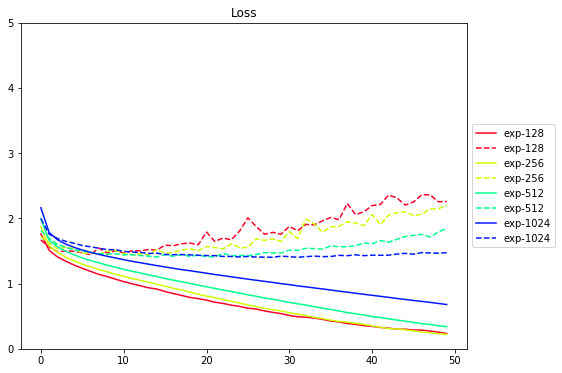

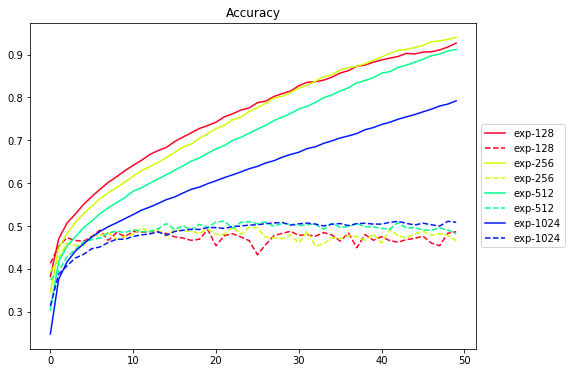

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
plot the results
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
